In [2]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations

import jax.random
import jax.numpy as jnp
import jax.scipy.optimize
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from functools import partial

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.ioff()

import time
import pandas as pd
from datetime import datetime
import os
import pytz
import ast
from pypdf import PdfMerger

import contextlib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Running parameters
num_iters = 2    # Number of training iterations
num_runs = 1
cl_types = ["NCL"]#, "CL", "ACL", "SPCL", "SPACL"]     # "NCL" - No curriculum, "CL" - Curriculum, "ACL" - Anti-curriculum, "SPCL" - Self paced curriculum, "SPACL" - Self paced anti-curriculum

# Circuit parameters
nqubits = 9
error_type = 4 # 0-"BitFlip", 1-"PhaseFlip", 2-"AmplitudeDamping", 3-"PhaseDamping", 4-"DepolarizingChannel"
error_prob = 0.1

# Data hyper-parameters
batch_size = 6    # batch training size
train_size = 6    # Total states that will be used for training
# val_size = 0      # Total states that will be used for validation
cl_batch_ratios = [1/3, 1/3, 1/3]  # [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
cl_iter_ratios  = [1/4, 1/4, 1/2]  # [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]

# Optimization parameters
optimizer = "Adam"  # "Adam", "GradientDescent", "BFGS"
loss_type = "fidelity" # "fidelity"
initialization = "gaussian" # "gaussian", "uniform"
max_weight_init = 2*np.pi  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.01         # stepsize of the gradient descent.

# Constant definitions
cl_batches = []
i_batch_size = 0
for i in range(len(cl_iter_ratios)):
    if i < len(cl_iter_ratios)-1:
        i_batch_size += int(cl_batch_ratios[i]*train_size)
        i_num_iters = int(cl_iter_ratios[i]*num_iters)
    else:
        i_batch_size = train_size
        i_num_iters = num_iters - len(cl_batches)
        
    cl_batches += [i_batch_size]*i_num_iters

error_types = {0:"BitFlip", 1:"PhaseFlip", 2:"AmplitudeDamping", 3:"PhaseDamping", 4:"DepolarizingChannel"}
circuit_types = {0:"Variational", 1:"Shor", 2:"Only noise"}


# Generate dataset

In [4]:
def X(i):
    return qml.PauliX(i)

def Y(i):
    return qml.PauliY(i)

def Z(i):
    return qml.PauliZ(i)

In [5]:
def generate_dataset():
    x_matrix = qml.matrix(X(0))
    _, x_eigvecs = np.linalg.eigh(x_matrix)
    
    y_matrix = qml.matrix(Y(0))
    _, y_eigvecs = np.linalg.eigh(y_matrix)

    z_matrix = qml.matrix(Z(0))
    _, z_eigvecs = np.linalg.eigh(z_matrix)
    
    eigvecs = np.concatenate((x_eigvecs, y_eigvecs, z_eigvecs), axis=1)
    eigvecs = [np.tensordot(e, np.conjugate(e), axes=0) for e in eigvecs.T]

    return np.array(eigvecs)

# Quantum Circuit

In [6]:
def general_unitary_2q(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

def general_unitary_3q(q1, q2, q3, weights):
    general_unitary_2q(q1, q2, weights[0:15])
    general_unitary_2q(q2, q3, weights[15:30])
    general_unitary_2q(q3, q1, weights[30:45])

def bitFlip(error_prob, i):
    qml.BitFlip(error_prob, i)
    return 0

def phaseFlip(error_prob, i):
    qml.PhaseFlip(error_prob, i)
    return 0

def amplitudeDamping(error_prob, i):
    qml.AmplitudeDamping(error_prob, i)
    return 0

def phaseDamping(error_prob, i):
    qml.PhaseDamping(error_prob, i)
    return 0

def depolarizingChannel(error_prob, i):
    qml.DepolarizingChannel(error_prob, i)
    return 0

def noise_channel(error_prob, error_type):
    for i in range(nqubits):
        jnp.where(error_type == 0, bitFlip(error_prob, i), True)
        jnp.where(error_type == 1, phaseFlip(error_prob, i), True)
        jnp.where(error_type == 2, amplitudeDamping(error_prob, i), True)
        jnp.where(error_type == 3, phaseDamping(error_prob, i), True)
        jnp.where(error_type == 4, depolarizingChannel(error_prob, i), True)
        
        # if error_type == 0:
        #     bitFlip(error_prob, i)
        # if error_type == 1:
        #     phaseFlip(error_prob, i)
        # if error_type == 2:
        #     amplitudeDamping(error_prob, i)
        # if error_type == 3:
        #     phaseDamping(error_prob, i)
        # if error_type == 4:
        #     depolarizingChannel(error_prob, i)

In [7]:
def variational_channel(weights, error_prob, error_type):
    # https://pennylane.ai/blog/2021/05/how-to-simulate-noise-with-pennylane/
    w_u1 = weights[0:45]
    w_u2 = weights[45:90]
    
    qml.adjoint(general_unitary_3q)(1, 4, 7, w_u2)
    qml.adjoint(general_unitary_3q)(0, 1, 2, w_u1)
    qml.adjoint(general_unitary_3q)(3, 4, 5, w_u1)
    qml.adjoint(general_unitary_3q)(6, 7, 8, w_u1)
    
    noise_channel(error_prob, error_type)
    
    general_unitary_3q(6, 7, 8, w_u1)
    general_unitary_3q(3, 4, 5, w_u1)
    general_unitary_3q(0, 1, 2, w_u1)
    general_unitary_3q(1, 4, 7, w_u2)
    

dev = qml.device("default.mixed", wires=nqubits)
@jax.jit
@qml.qnode(dev, interface="jax")
def variational_circuit(weights, state_ini, error_prob, error_type):
    qml.QubitDensityMatrix(state_ini, wires=[4])
    variational_channel(weights, error_prob, error_type)
    return qml.density_matrix([4])

In [8]:
def shor_channel(error_prob, error_type):
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 6])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=6)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[6, 7])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[3, 5])
    qml.CNOT(wires=[6, 8])
    noise_channel(error_prob, error_type)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[6, 7])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[3, 5])
    qml.CNOT(wires=[6, 8])
    qml.Toffoli(wires=[2,1,0])
    qml.Toffoli(wires=[5,4,3])
    qml.Toffoli(wires=[8,7,6])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=6)
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 6])
    qml.Toffoli(wires=[6,3,0])

dev = qml.device("default.mixed", wires=nqubits)
@qml.qnode(dev)
def shor_circuit(state_ini, error_prob, error_type):
    qml.QubitDensityMatrix(state_ini, wires=[0])
    shor_channel(error_prob, error_type)
    return qml.density_matrix([0])

In [9]:
dev = qml.device("default.mixed", wires=nqubits)
@qml.qnode(dev)
def only_noise_circuit(state_ini, error_prob, error_type):
    qml.QubitDensityMatrix(state_ini, wires=[4])
    noise_channel(error_prob, error_type)
    return qml.density_matrix([4])

In [10]:
@jax.jit
def circuit(weights, state_ini, error_prob, error_type, circuit_type):
    # if circuit_type == 0:
    #     state_out = variational_circuit(weights, state_ini, error_prob, error_type)
    # elif circuit_type == 1:
    #     state_out = shor_circuit(state_ini, error_prob, error_type)
    # elif circuit_type == 2:
    #     state_out = only_noise_circuit(state_ini, error_prob, error_type)
    
    state_out = jnp.where(circuit_type == 0, variational_circuit(weights, state_ini, error_prob, error_type), jnp.where(circuit_type == 1, shor_circuit(state_ini, error_prob, error_type), only_noise_circuit(state_ini, error_prob, error_type)))

    return state_out

# Loss and accuracy

In [11]:
@jax.jit
def single_loss(weights, ini_state, error_prob, error_type, circuit_type):
    
    out_state = circuit(weights, ini_state, error_prob, error_type, circuit_type)

    if loss_type == "fidelity":
        cost = 1 - qml.math.fidelity(out_state, ini_state)
    
    return cost


@jax.jit
def loss(weights, ini_states, error_prob, error_type, circuit_type):
    costs = jax.vmap(single_loss, in_axes=[None, 0, None, None, None])(weights, ini_states, error_prob, error_type, circuit_type)
    return costs.sum()/len(ini_states)

# Processing Data

In [12]:
def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, bbox_inches='tight', format='pdf')
    pp.close()


def close_all_figures():
    fig_nums = plt.get_fignums()
    for n in fig_nums:
        plt.figure(n)
        plt.close()


def save_plots(time_now,
               folder_name,
               file_name,
               plot_run,
               losses_train
            #    losses_val
              ):


    fig, axis = plt.subplots(1,1)
    # fig.set_figheight(6.5)
    # fig.set_figwidth(15)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped # rect=(1,1,5,1)

    # ---------------------------------------------------------------------- #
    # -------------------- Loss and accuracy figure ------------------------ #
    # ---------------------------------------------------------------------- #

    iterations = range(1, num_iters+1)

    color2 = 'darkblue'
    axis.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
    axis.plot(iterations, losses_train, label="Train Loss", color=color2)
    # axis.plot(iterations, losses_val, '-.', label="Val. Loss", color=color2)
    axis.tick_params(axis='y', labelcolor=color2)
    axis.set_yscale("log")
    # axis.set_ylim(bottom=0.0, top=1.0)

    # plt.legend()
    axis.set_title(f"Training and Validation Loss - Run {plot_run} ({losses_train[num_iters-1]:.2E})") #/{losses_val[num_iters-1]:.2E})")
    
    # ---------------------------------------------------------------------- #
    # --------------------------- Save plots ------------------------------- #
    # ---------------------------------------------------------------------- #

    plots_pdf_name = f"{folder_name}/{time_now} - Plots - {file_name}.pdf"
    
    
    # If the file doesn't exist we save it. If it does, we merge it.
    if not os.path.isfile(plots_pdf_name):
        save_multi_image(plots_pdf_name)
    
    else:
        save_multi_image(plots_pdf_name + "2")
        # Merge the new plot with the rest and delete the last file
        merger = PdfMerger()
        merger.append(plots_pdf_name)
        merger.append(plots_pdf_name + "2")
        merger.write(plots_pdf_name)
        merger.close()
        os.remove(plots_pdf_name + "2")
    
    close_all_figures()

In [13]:
def save_hyperparameters(time_now, folder_name, file_name):
    
    # --------------- Hyperparameters -----------------#
    hyperparameters = {}
    hyperparameters["num_iters"] = [num_iters]
    hyperparameters["num_runs"] = [num_runs]
    hyperparameters["cl_types"] = [cl_types]
    hyperparameters["nqubits"] = [nqubits]
    hyperparameters["error_type"] = [error_types[error_type]]
    hyperparameters["error_prob"] = [error_prob]
    hyperparameters["batch_size"] = [batch_size]
    hyperparameters["train_size"] = [train_size]
    hyperparameters["cl_batch_ratios"] = [cl_batch_ratios]
    hyperparameters["cl_iter_ratios"] = [cl_iter_ratios]
    hyperparameters["optimizer"] = [optimizer]
    hyperparameters["loss_type"] = [loss_type]
    hyperparameters["initialization"] = [initialization]
    hyperparameters["max_weight_init"] = [max_weight_init]
    hyperparameters["stepsize"] = [stepsize]
    hyperparameters["key"] = [time_now]

    hyperparameters = pd.DataFrame(hyperparameters)

    hyperparameters_file_name = f"{folder_name}/{time_now} - Hyperparameters{file_name}.csv"
    hyperparameters.to_csv(hyperparameters_file_name, index=False, mode='a', header = not os.path.exists(hyperparameters_file_name))

In [14]:
def save_data(time_now,
              folder_name,
              run,
              weights,
              losses_train,
            #   losses_val,
              run_time,
              cl
              ):
    
    # -------------------- Total Data -------------------- #
    data = {}
    data["run"] = run
    data["run_time"] = run_time
    data["weights"] = weights
    data["losses_train"] = losses_train
    # data["losses_val"] = [losses_val]
    

    data = pd.DataFrame(data)
    
    data_file_name = f"{folder_name}/{time_now} - Data - {cl}.csv"
    data.to_csv(data_file_name, index=False, mode='a', header = not os.path.exists(data_file_name))
    
    
    # ------------------- Plots ------------------- #
    save_plots(time_now,
               folder_name,
               cl,
               run,
               losses_train
            #    losses_val
              )
    
    if cl == "NCL":
        cl_str = "NCL  "
    elif cl=="CL":
        cl_str = "CL   "
    elif cl=="ACL":
        cl_str = "ACL  "
    elif cl=="SPCL":
        cl_str = "SPCL "
    elif cl=="SPACL":
        cl_str = "SPACL"
        
    print(
        f" {cl_str} |"
        f" {run:3d} |"
        f" {run_time:0.0f}"
    )
    
    

In [17]:
def save_plots_error_rate(time_now, folder_name):

    # hyperparams_file_name_shor = f"Results/Shor/Hyperparameters Shor code - {error_types[error_type]}.csv"
    # read_hyperparams_shor = pd.read_csv(hyperparams_file_name_shor, usecols=["error_prob"])
    # error_probs_shor = list(read_hyperparams_shor["error_prob"])

    # data_file_name_shor = f"Results/Shor/Data Shor code - {error_types[error_type]}.csv"
    # read_data_shor = pd.read_csv(data_file_name_shor, usecols=["losses_train"], converters={"losses_train":ast.literal_eval})
    # losses_shor = np.array(list(map(np.array, read_data_shor["losses_train"])))[:,-1]

    hyperparams_file_name = f"{folder_name}/{time_now} - Hyperparameters.csv"
    read_hyperparams = pd.read_csv(hyperparams_file_name, usecols=["error_prob"])
    error_probs = list(read_hyperparams["error_prob"])


    if cl_types == ["NCL", "CL", "ACL", "SPCL", "SPACL"]:
        arr_file_names = [["NCL","CL","ACL"], ["SPCL","SPACL"]]
    else:
        arr_file_names = [cl_types]
        
    for file_names in arr_file_names:

        fig, axis = plt.subplots(1,len(file_names))
        if len(file_names) == 1:
            axis = [axis]
            fig.tight_layout(rect=(0,0,0,0))
        else:
            fig.set_figheight(6)
            fig.set_figwidth(7*len(file_names))
            fig.tight_layout(pad=4, w_pad=7)
        
        i = 0
        for file_name in file_names:
            
            data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"
            read_data = pd.read_csv(data_file_name,
                                    usecols=["losses_train"],
                                    converters={"losses_train":ast.literal_eval})
            last_losses_train = np.array(list(map(np.array, read_data["losses_train"])))[:,-3]
            losses_shor = np.array(list(map(np.array, read_data["losses_train"])))[:,-2]
            losses_noise = np.array(list(map(np.array, read_data["losses_train"])))[:,-1]

            # ---------------------------------------------------------------------- #
            # -------------------- Loss and accuracy figure ------------------------ #
            # ---------------------------------------------------------------------- #

            color1 = "darkred"
            color2 = "darkblue"
            color3 = "black"
            axis[i].set_xlabel('Error rate')
            axis[i].set_ylabel('Loss')
            axis[i].plot(error_probs, losses_shor, label="Shor loss", color=color1)
            axis[i].plot(error_probs, last_losses_train, label="Variational loss", color=color2)
            axis[i].plot(error_probs, losses_noise, '-.', label="Only noise loss", color=color3)
            axis[i].set_yscale("log")
            axis[i].set_xscale("log")
            axis[i].set_title(f"Last training loss vs error rate with {error_types[error_type]} error - {file_name}")
            axis[i].legend()
            i += 1
    
    plots_pdf_name = f"{folder_name}/{time_now} - Plots error rate.pdf"
    save_multi_image(plots_pdf_name)
    close_all_figures()

# Training

In [18]:
@jax.jit
def sort_states(w, ini_states, ascending, error_prob, error_type, circuit_type):
    scores = jax.vmap(single_loss, in_axes=[None, 0, None, None, None])(jnp.array(w), jnp.array(ini_states), error_prob, error_type, circuit_type)
    
    p = jnp.where(ascending, scores.argsort(), scores.argsort()[::-1])
    
    return ini_states[p]

In [19]:
def train_qcnn(train_states, opt, cl, error_prob, error_type):
    
    if initialization == "uniform":
        weights_init = np.random.uniform(0, max_weight_init, 90)
    elif initialization == "gaussian":
        weights_init = np.random.normal(0, 1/np.sqrt(nqubits), 90)
        
    #Initiaize variables
    weights = []
    losses_train = []
    # losses_val = []

    w = weights_init
    state = opt.init_state(weights_init, train_states[:2], error_prob, error_type, circuit_type=0)
    
    for it in range(num_iters):
        
        # For self paced learning, we sort the datapoints at every iteration
        if cl in ["SPCL", "SPACL"]:
            ascending = True if cl == "SPCL" else False
            train_states = sort_states(w, train_states, ascending, error_prob, error_type, circuit_type=0)
            
        # Once they are sorted, we select the first datapoints into the batch lists
        if cl in ["CL", "ACL", "SPCL", "SPACL"]:
            train_states_batch = train_states[:cl_batches[it]]
        
        elif cl == "NCL":
            batch_index = np.random.default_rng().choice(len(train_states), size=batch_size, replace=False)
            train_states_batch = train_states[batch_index]

            
        # Update the weights by one optimizer step
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            w, state = opt.update(w, state, train_states_batch, error_prob, error_type, circuit_type=0)
        
        if optimizer == "GradientDescent":
            l_train = loss(w, train_states_batch, error_prob, error_type, circuit_type=0)
        else:
            l_train = state.value
            
        weights.append(w.tolist())
        losses_train.append(l_train)
    
    l_shor = loss(_, train_states, error_prob, error_type, circuit_type=1)
    l_noise = loss(_, train_states, error_prob, error_type, circuit_type=2)
    losses_train.append(l_shor)
    losses_train.append(l_noise)

    return weights, losses_train #, losses_val

In [20]:
def main():

    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):

    time_now = datetime.now(pytz.timezone('Europe/Andorra')).strftime("%Y-%m-%d %H-%M-%S")

    folder_name = f"Results/{nqubits}q - {num_iters:} iters/"
    if not os.path.isdir(f'{folder_name}'):
        os.makedirs(f'{folder_name}')

    # t = time.time()
    # key = jax.random.PRNGKey(int((t-int(t))*10**10))  # We start with a random (depending on time) seed for the jax keys

    # choose variational classifier
    if optimizer == "GradientDescent":
        opt = jaxopt.GradientDescent(loss, stepsize=stepsize, verbose=False, jit=True)
    elif optimizer == "Adam":
        opt = jaxopt.OptaxSolver(loss, optax.adam(stepsize), verbose=False, jit=True)
    elif optimizer == "BFGS":
        opt = jaxopt.BFGS(loss, verbose=False, jit=True)
    
    
    step = (np.log(10**(-1)) - np.log(10**(-4)))/9

    error_probs = []
    xpoint = np.log(10**(-4))
    for i in range(10):
        val = np.exp(xpoint)
        error_probs.append(val)
        xpoint += step
        
    num_runs = len(error_probs)
    run = 0
    global error_prob
    for error_prob in error_probs:
        
        save_hyperparameters(time_now, folder_name, file_name="")
        
        # -------------------------------------------------------------- #
        # ------------------- Generate ground states ------------------- #
        # -------------------------------------------------------------- #
        
        print("Generating dataset...")
        start_time = time.time()
        
        states = generate_dataset()
        
        train_states = states[:train_size]
        # val_states = states[train_size:]
        
        run_time = time.time() - start_time

        print(f"Dataset generated - {run_time:.0f}s")
        print()
        print("Max train / Last run")
        print("---------------------")
        print("  CL   | Run | Time  ")
        print("---------------------")
        
        
        for cl in cl_types:
            # ----------------------------------------------------------------------------------------------- #
            # ------------------------ Sort training gs by their score if curriculum ------------------------ #
            # ----------------------------------------------------------------------------------------------- #

            if cl in ["CL", "ACL"]:
                score_it = num_iters-1
                ascending = True if cl == "CL" else False
                train_states = sort_states(weights_ncl[score_it], train_states, ascending, error_prob, error_type, circuit_type=0)

            # ------------------------------------------------------------ #
            # ------------------------ Train QCNN ------------------------ #
            # ------------------------------------------------------------ #

            start_time = time.time()

            weights, \
            losses_train = train_qcnn(train_states, opt, cl, error_prob, error_type)

            run_time = time.time() - start_time
            
            if cl == "NCL":
                weights_ncl = weights

            # --------------------------------------------------------- #
            # ------------------- Save calculations ------------------- #
            # --------------------------------------------------------- #
            save_data(time_now,
                      folder_name,
                      run,
                      weights,
                      losses_train,
                      run_time,
                      cl
                      )

        print("---------------------")
        print()
        run += 1
    
    save_plots_error_rate(time_now, folder_name)

# Execution

In [21]:
main()

Generating dataset...
Dataset generated - 0s

Max train / Last run
---------------------
  CL   | Run | Time  
---------------------


KeyboardInterrupt: 

# Miscellaneous

<function matplotlib.pyplot.show(close=None, block=None)>

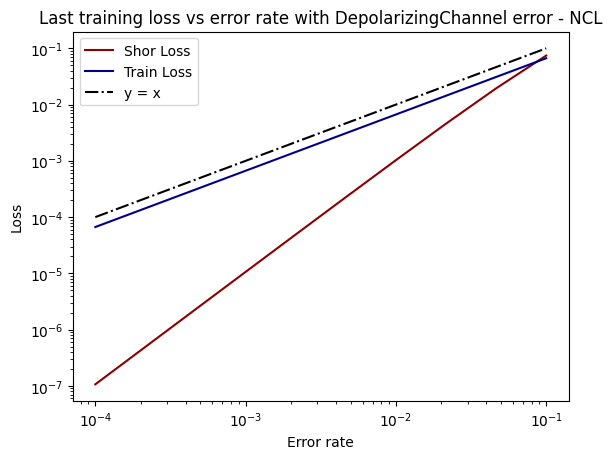

In [9]:
folder_name = "Results/9q - 200 iters"
cl_types = ["NCL"]
num_iters = 200
time_now = "2024-02-28 22-00-39"
error_type_str = "DepolarizingChannel"

hyperparams_file_name_shor = f"Results/Shor/Hyperparameters Shor code - {error_types[error_type]}.csv"
read_hyperparams_shor = pd.read_csv(hyperparams_file_name_shor, usecols=["error_prob"])
error_probs_shor = list(read_hyperparams_shor["error_prob"])

data_file_name_shor = f"Results/Shor/Data Shor code - {error_types[error_type]}.csv"
read_data_shor = pd.read_csv(data_file_name_shor, usecols=["losses_train"], converters={"losses_train":ast.literal_eval})
losses_shor = np.array(list(map(np.array, read_data_shor["losses_train"])))[:,-1]


hyperparams_file_name = f"{folder_name}/{time_now} - Hyperparameters.csv"
read_hyperparams = pd.read_csv(hyperparams_file_name, usecols=["error_prob"])
error_probs = list(read_hyperparams["error_prob"])


if cl_types == ["NCL", "CL", "ACL", "SPCL", "SPACL"]:
    arr_file_names = [["NCL","CL","ACL"], ["SPCL","SPACL"]]
else:
    arr_file_names = [cl_types]
    
for file_names in arr_file_names:

    fig, axis = plt.subplots(1,len(file_names))
    if len(file_names) == 1:
        axis = [axis]
        fig.tight_layout(rect=(0,0,0,0))
    else:
        fig.set_figheight(6)
        fig.set_figwidth(7*len(file_names))
        fig.tight_layout(pad=4, w_pad=7)
    
    i = 0
    for file_name in file_names:
        
        data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"
        read_data = pd.read_csv(data_file_name,
                                usecols=["losses_train"],
                                converters={"losses_train":ast.literal_eval})
        last_losses_train = np.array(list(map(np.array, read_data["losses_train"])))[:,num_iters-1]

        # ---------------------------------------------------------------------- #
        # -------------------- Loss and accuracy figure ------------------------ #
        # ---------------------------------------------------------------------- #

        color1 = "darkred"
        color2 = "darkblue"
        color3 = "black"
        axis[i].set_xlabel('Error rate')
        axis[i].set_ylabel('Loss')
        axis[i].plot(error_probs_shor, losses_shor, label="Shor Loss", color=color1)
        axis[i].plot(error_probs, last_losses_train, label="Train Loss", color=color2)
        axis[i].plot(error_probs, error_probs, '-.', label="y = x", color=color3)
        axis[i].set_yscale("log")
        axis[i].set_xscale("log")
        axis[i].set_title(f"Last training loss vs error rate with {error_types[error_type]} error - {file_name}")
        axis[i].legend()
        i += 1
plt.show
# plots_pdf_name = f"{folder_name}/{time_now} - Plots error rate.pdf"
# save_multi_image(plots_pdf_name)
# close_all_figures()
    